In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## Part 6

In [2]:
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [3]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [4]:
D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


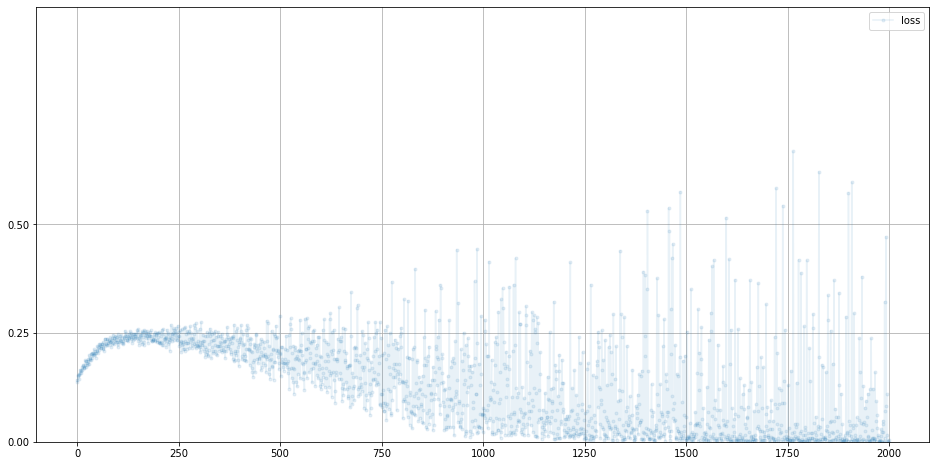

In [5]:
D.plot_progress()

In [6]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7886573672294617
0.047111235558986664


In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
        
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [8]:
G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.6546, 0.5995, 0.4224, 0.4376], grad_fn=<SigmoidBackward>)

In [9]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.5 s


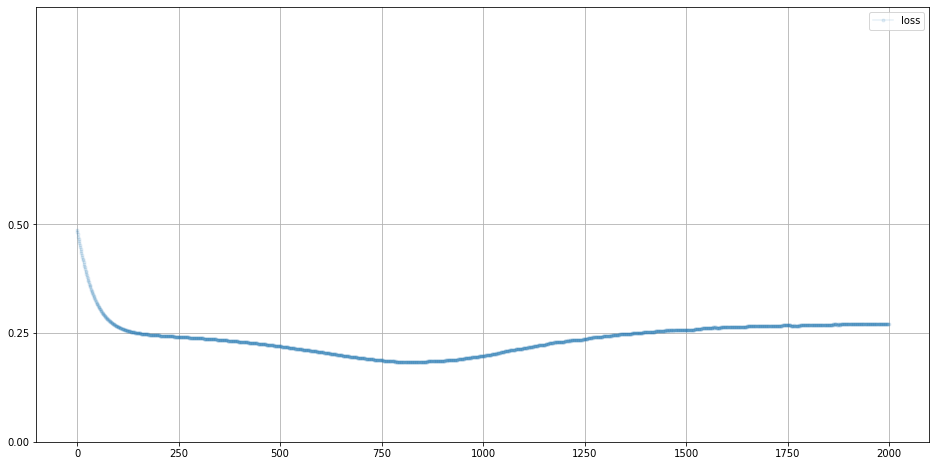

In [10]:
D.plot_progress()

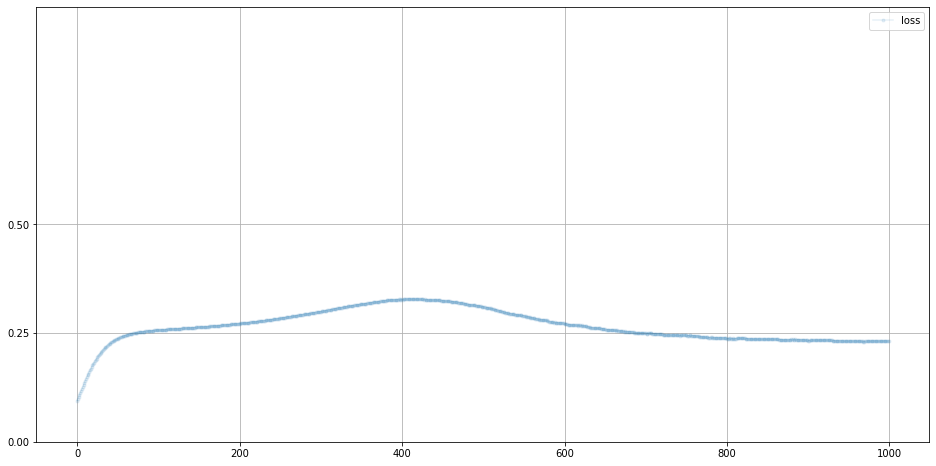

In [11]:
G.plot_progress()

In [12]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9331, 0.0450, 0.9433, 0.0414], grad_fn=<SigmoidBackward>)

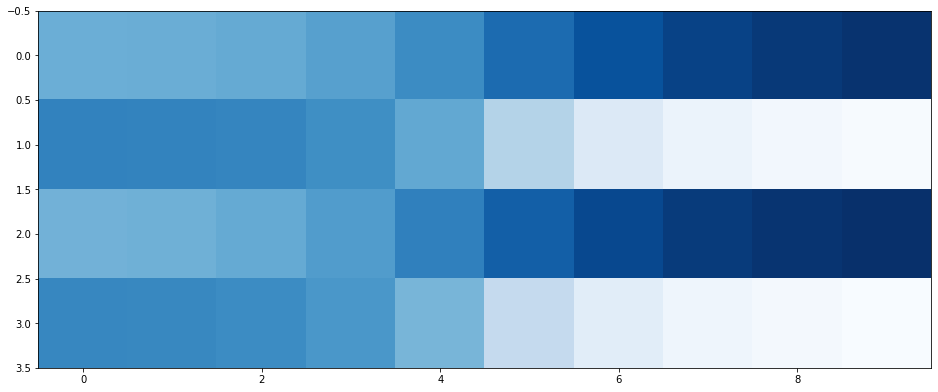

In [13]:
plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

## Part 7

In [14]:
from torch.utils.data import Dataset

In [15]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [16]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [17]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/data_gan/mnist_train.csv')

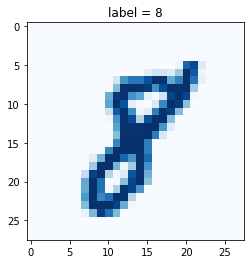

In [18]:
mnist_dataset.plot_image(17)

In [19]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [20]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass   



In [21]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


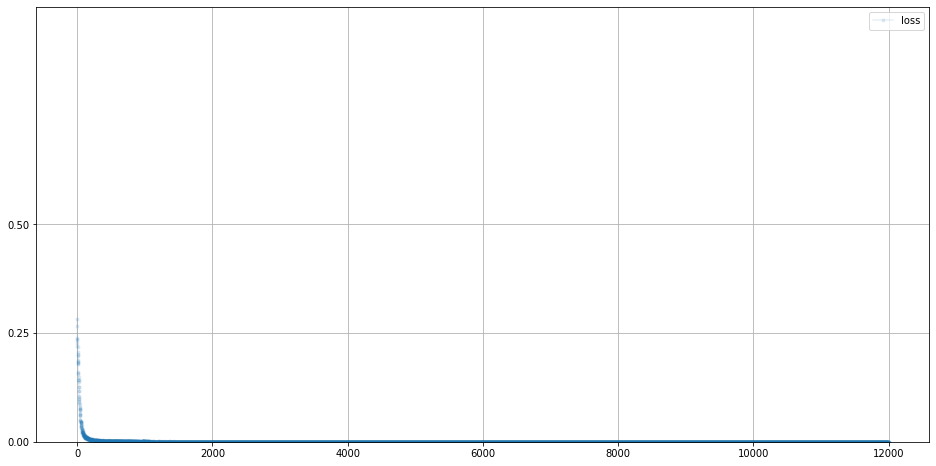

In [22]:
D.plot_progress()

In [23]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random(784) ).item() )
  pass

0.9942849278450012
0.9951849579811096
0.9951066970825195
0.9960403442382812
0.0046738432720303535
0.005652509164065123
0.004378832411020994
0.005455614998936653


In [24]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

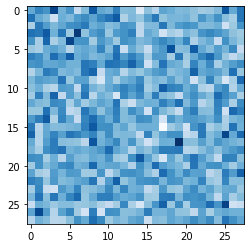

In [25]:
G = Generator()

output = G.forward(generate_random(1))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass

counter =  10000


In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

## Part 8

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784) ).item() )
  pass

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time 

# create

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train
  for label, image_data_tensor, target_tensor in mnist_dataset:

    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
  
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 30min 52s, sys: 33.5 s, total: 31min 26s
Wall time: 31min 25s


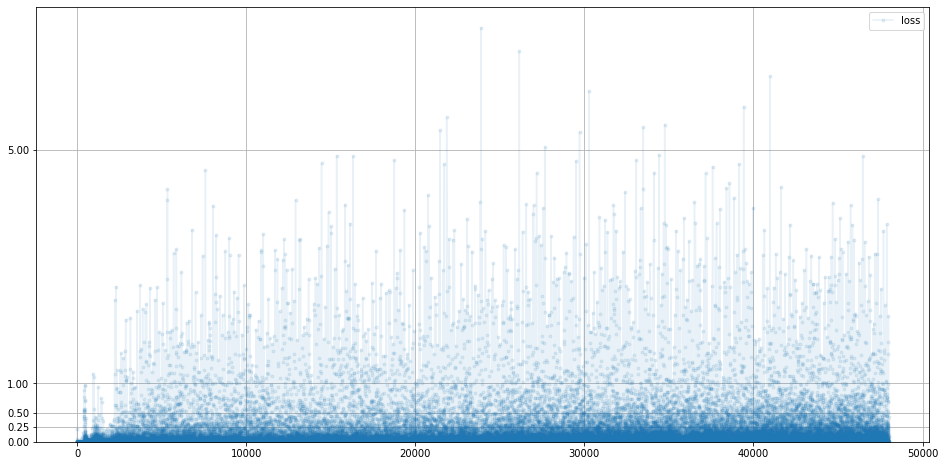

In [ ]:
D.plot_progress()

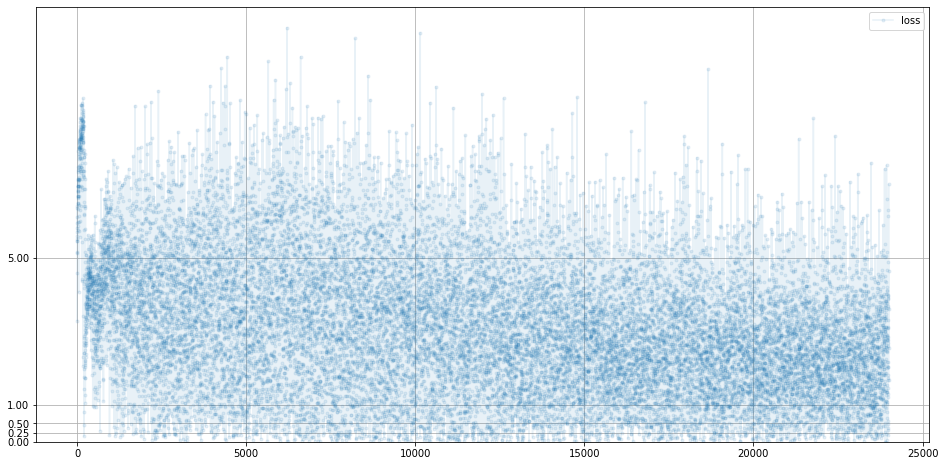

In [ ]:
G.plot_progress()

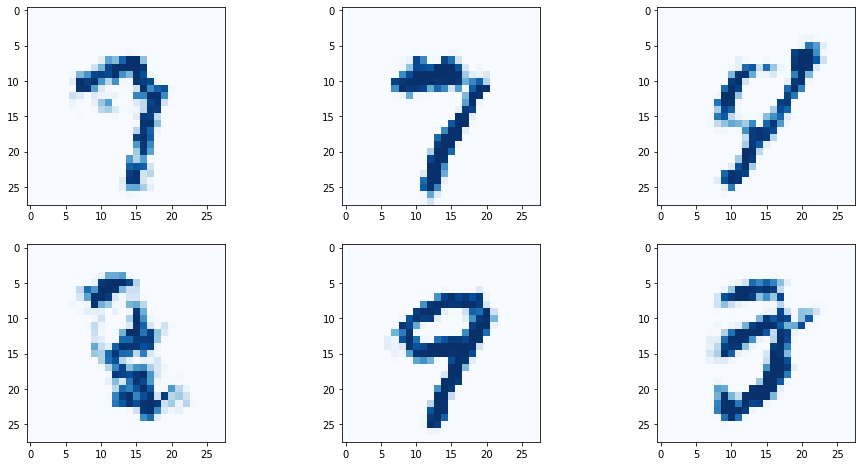

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

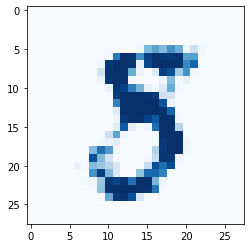

In [ ]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

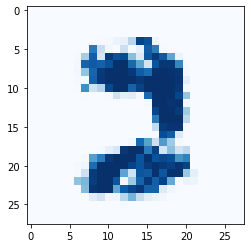

In [ ]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

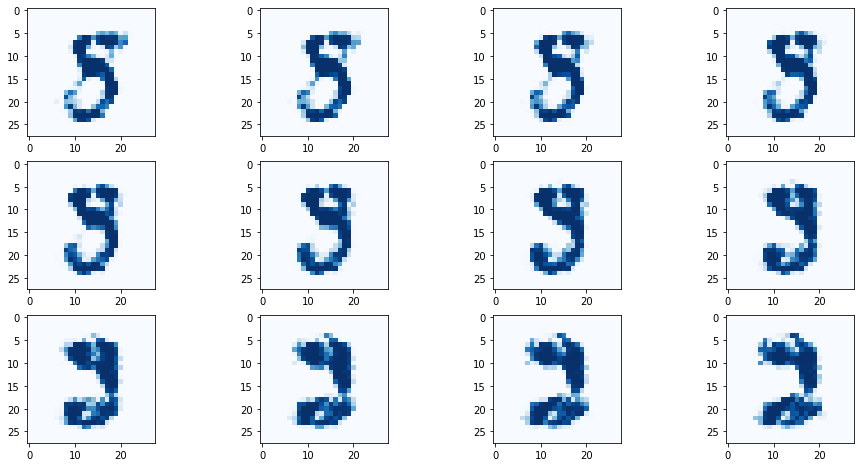

In [ ]:
count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

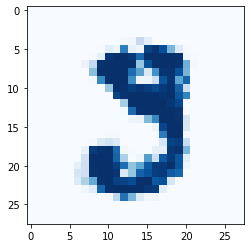

In [ ]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

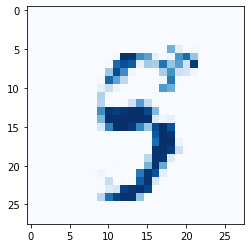

In [ ]:
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

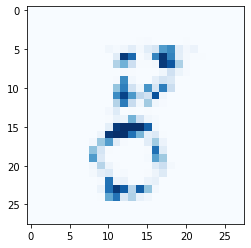

In [ ]:
seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

## Part 9

In [ ]:
import torchvision
import h5py
import zipfile
import imageio
import os

In [ ]:

%%time

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = 'mount/My Drive/Colab Notebooks/data_gan/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('celeba/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

IsADirectoryError: ignored

In [ ]:
with h5py.File('mount/My Drive/Colab Notebooks/data_gan/celeba_aligned_small.h5py', 'r') as file_object:
  
  for group in file_object:
    print(group)
    pass

In [ ]:
with h5py.File('mount/My Drive/Colab Notebooks/data_gan/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass

KeyError: ignored

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [ ]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [ ]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/data_gan/celeba_aligned_small.h5py')

OSError: ignored

In [ ]:
celeba_dataset.plot_image(43)

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:

%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))